<h2><font color='#306998'><center>451 Financial Engineering: Programming Assignment 1</center></font></h2>
<h3><center>Eli Freedman, October 5, 2025</center></h3>

# Overview

The Broken Hill Proprietary Company Limited, commonly known as BHP, was founded in 1885 in Broken Hill, New South Wales, after the discovery of one of the world’s richest silver, lead, and zinc deposits. Originally established as a mining company, BHP quickly grew into a major player in Australia’s industrial development, expanding into steel production in the early 20th century with operations in Newcastle and later Whyalla and Port Kembla. Over time, the company diversified into coal, petroleum, iron ore, and copper, becoming one of the world’s largest resource companies. In 2001, BHP merged with the Anglo-Dutch mining company Billiton, forming BHP Billiton, before simplifying its name back to BHP in 2017. Today, BHP is a global leader in natural resources, headquartered in Melbourne, Australia, with operations across multiple continents.

This analysis investigates predicting the direction of the price of the stock using stock data sourced from Yahoo! as well as several engineered features.

**Disclaimer**: The majority of the code below is sourced from Professor Thomas W. Miller's jumpstart code for Programming Assignment 1. Alterations were made where necessary to work specifically with data relating to $BHP, and additions were added where required.

# Imports

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Python Packages for data manipulation, data pipelines, and databases
import numpy as np
import pyarrow # foundation for polars
import polars as pl # DataFrame work superior to Pandas

# Plotting
import matplotlib.pyplot as plt
# Display static plots directly in the notebook output 
%matplotlib inline
# create stylized visualizations, including heat maps
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (RandomizedSearchCV, 
                                    TimeSeriesSplit)
from sklearn.model_selection import cross_validate

# needed for randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# metrics in xgboost tuning and final model evaluation
from sklearn.metrics import (classification_report,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             confusion_matrix
                            )

# XGBoost Package... more complete than SciKit-Learn boosting methods
import xgboost as xgb
from xgboost import XGBClassifier

import yfinance as yf

# Data Ingestion

In [2]:
symbol = 'BHP'
start_date = '2000-01-01'
end_date = '2025-09-30'

ticker = yf.Ticker(symbol)
historical_data = ticker.history(start = start_date, end = end_date)
print(historical_data)

print("type of historical_data", type(historical_data))

historical_data.to_csv("bhp_historical_data.csv")

                                Open       High  ...  Dividends  Stock Splits
Date                                             ...                         
2000-01-03 00:00:00-05:00   3.129319   3.129319  ...        0.0           0.0
2000-01-04 00:00:00-05:00   3.188224   3.188224  ...        0.0           0.0
2000-01-05 00:00:00-05:00   3.151409   3.195587  ...        0.0           0.0
2000-01-06 00:00:00-05:00   3.166135   3.180861  ...        0.0           0.0
2000-01-07 00:00:00-05:00   3.239765   3.357575  ...        0.0           0.0
...                              ...        ...  ...        ...           ...
2025-09-23 00:00:00-04:00  53.419998  53.599998  ...        0.0           0.0
2025-09-24 00:00:00-04:00  53.410000  53.770000  ...        0.0           0.0
2025-09-25 00:00:00-04:00  54.900002  55.730000  ...        0.0           0.0
2025-09-26 00:00:00-04:00  54.990002  55.090000  ...        0.0           0.0
2025-09-29 00:00:00-04:00  55.549999  56.500000  ...        0.0 

# Feature Engineering

Here, I added two additional features on top of the features developed by Professor Miller.

1. CloseSMA5: A 5-day simple moving average of lagged closing prices, representing a short-term price trend.
2. Normalized Volume (NormVolumeLag1): Yesterday’s volume divided by its 5-day rolling average, highlighting unusual trading activity relative to recent norms.

In [3]:
bhp = pl.read_csv("bhp_historical_data.csv", try_parse_dates=True)

# check the original schema
print(bhp.schema)

# drop useless columns Dividends and Stock Splits
bhp = bhp.drop(['Dividends', 'Stock Splits'])

# create lag price features
bhp = bhp.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
bhp = bhp.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
bhp = bhp.with_columns((pl.col('CloseLag2')).shift().alias('CloseLag3'))

# create high-minus-low (HML) for day and its lags
bhp = bhp.with_columns((pl.col('High') - pl.col('Low')).alias('HML'))
bhp = bhp.with_columns((pl.col('HML')).shift().alias('HMLLag1'))
bhp = bhp.with_columns((pl.col('HMLLag1')).shift().alias('HMLLag2'))
bhp = bhp.with_columns((pl.col('HMLLag2')).shift().alias('HMLLag3'))

# create a net change for the day as the open minus closing price OMC
# also create the corresponding lag metrics
bhp = bhp.with_columns((pl.col('Open') - pl.col('Close')).alias('OMC'))
bhp = bhp.with_columns((pl.col('OMC')).shift().alias('OMCLag1'))
bhp = bhp.with_columns((pl.col('OMCLag1')).shift().alias('OMCLag2'))
bhp = bhp.with_columns((pl.col('OMCLag2')).shift().alias('OMCLag3'))

# create volume lag metrics
bhp = bhp.with_columns((pl.col('Volume')).shift().alias('VolumeLag1'))
bhp = bhp.with_columns((pl.col('VolumeLag1')).shift().alias('VolumeLag2'))
bhp = bhp.with_columns((pl.col('VolumeLag2')).shift().alias('VolumeLag3'))

# compute 10-day exponential moving averages of closing prices
# compute acround CloseLag1 to avoid any "leakage" in explanatory variable set
# note also the 10-day buffer between train and test in time-series cross-validation
bhp = bhp.with_columns((pl.col('CloseLag1').ewm_mean(half_life=1,ignore_nulls=True)).alias('CloseEMA2'))
bhp = bhp.with_columns((pl.col('CloseLag1').ewm_mean(half_life=2,ignore_nulls=True)).alias('CloseEMA4'))
bhp = bhp.with_columns((pl.col('CloseLag1').ewm_mean(half_life=4,ignore_nulls=True)).alias('CloseEMA8'))

# log daily returns
bhp = bhp.with_columns(np.log(pl.col('Close')/pl.col('CloseLag1')).alias('LogReturn'))

# set volume features to Float64 for subsequent use in Numpy arrays
bhp = bhp.with_columns(
    pl.col('Volume').cast(pl.Float64).round(0),
    pl.col('VolumeLag1').cast(pl.Float64).round(0),
    pl.col('VolumeLag2').cast(pl.Float64).round(0),
    pl.col('VolumeLag3').cast(pl.Float64).round(0),
    )

# rolling 5-day mean of lagged close (safe, since it only uses lagged closes)
bhp = bhp.with_columns(pl.col('CloseLag1').rolling_mean(window_size=5).alias('CloseSMA5'))

# normalized volume using only lagged volume
bhp = bhp.with_columns((pl.col('VolumeLag1') / pl.col('VolumeLag1').rolling_mean(window_size=5)).alias('NormVolumeLag1'))

# round other features to three decimal places for reporting and subsequent analytics
bhp = bhp.with_columns(
    pl.col('Open').round(3),
    pl.col('High').round(3),    
    pl.col('Low').round(3),
    pl.col('Close').round(3),      
    pl.col('CloseLag1').round(3),
    pl.col('CloseLag2').round(3),  
    pl.col('CloseLag3').round(3),
    pl.col('HML').round(3),  
    pl.col('HMLLag1').round(3),
    pl.col('HMLLag2').round(3),  
    pl.col('HMLLag3').round(3),
    pl.col('OMC').round(3),  
    pl.col('OMCLag1').round(3),
    pl.col('OMCLag2').round(3),  
    pl.col('OMCLag3').round(3), 
    pl.col('CloseEMA2').round(3),
    pl.col('CloseEMA4').round(3), 
    pl.col('CloseEMA8').round(3),
    pl.col('CloseSMA5').round(3),
    pl.col('NormVolumeLag1').round(3)
)
    
# define binary target/response 1 = market price up since previous day, 0 = even or down 
bhp = bhp.with_columns(pl.when(pl.col('LogReturn')>0.0).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Target'))

print(bhp.schema)

# save to external comma-delimited text file for checking calculations in Excel
bhp.write_csv("bhp-with-computed-features.csv")

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'Dividends': Float64, 'Stock Splits': Float64})
Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Float64, 'CloseLag1': Float64, 'CloseLag2': Float64, 'CloseLag3': Float64, 'HML': Float64, 'HMLLag1': Float64, 'HMLLag2': Float64, 'HMLLag3': Float64, 'OMC': Float64, 'OMCLag1': Float64, 'OMCLag2': Float64, 'OMCLag3': Float64, 'VolumeLag1': Float64, 'VolumeLag2': Float64, 'VolumeLag3': Float64, 'CloseEMA2': Float64, 'CloseEMA4': Float64, 'CloseEMA8': Float64, 'LogReturn': Float64, 'CloseSMA5': Float64, 'NormVolumeLag1': Float64, 'Target': Int32})


# Exploratory Data Analysis

In [5]:
# Drop the rows with null values such as the initial lag rows
bhp = bhp.drop_nulls()

# Descriptive statistics
bhpStatistics = bhp.drop('Date').describe()

print(bhpStatistics.columns)

bhpStatisticsToPrint = bhpStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_7'])

print(bhpStatisticsToPrint.schema)

with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(bhpStatisticsToPrint)


['statistic', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'CloseLag3', 'HML', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMC', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'LogReturn', 'CloseSMA5', 'NormVolumeLag1', 'Target']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_6': String, 'column_8': String})
┌────────────────┬──────────┬───────────────────────┬──────────────────────┬──────────────────────┬───────────────────────┬─────────────────────┐
│ column         ┆ column_0 ┆ column_2              ┆ column_3             ┆ column_4             ┆ column_6              ┆ column_8            │
╞════════════════╪══════════╪═══════════════════════╪══════════════════════╪══════════════════════╪═══════════════════════╪═════════════════════╡
│ statistic      ┆ count    ┆ mean                  ┆ std                  ┆ min                  ┆ 50%  

In [6]:
# Select Features for the Model, exclude current day price variables ... no "leakage"
# note for moving averages, we have excluded the current day, and provide a 10-day gap
# so these may be included in the set 
X = bhp.drop(['Date', 'LogReturn', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume', 'HML', 'OMC'])
X.head()

CloseLag1,CloseLag2,CloseLag3,HMLLag1,HMLLag2,HMLLag3,OMCLag1,OMCLag2,OMCLag3,VolumeLag1,VolumeLag2,VolumeLag3,CloseEMA2,CloseEMA4,CloseEMA8,CloseSMA5,NormVolumeLag1
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3.358,3.144,3.196,0.118,0.074,0.074,-0.118,0.022,-0.044,292832.0,48358.0,234705.0,3.259,3.223,3.202,3.181,1.937
3.328,3.358,3.144,0.052,0.118,0.074,0.0,-0.118,0.022,101844.0,292832.0,48358.0,3.294,3.258,3.233,3.237,0.645
3.181,3.328,3.358,0.066,0.052,0.118,0.029,0.0,-0.118,66431.0,101844.0,292832.0,3.237,3.233,3.221,3.241,0.446
3.188,3.181,3.328,0.059,0.066,0.052,0.007,0.029,0.0,158017.0,66431.0,101844.0,3.213,3.219,3.214,3.24,1.184
3.21,3.188,3.181,0.052,0.059,0.066,0.007,0.007,0.029,90365.0,158017.0,66431.0,3.211,3.216,3.213,3.253,0.637


In [7]:
# Define and examine the target for regression model development
print(bhp['LogReturn'].describe())

y = np.array(bhp['LogReturn'])

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 6469.0    │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.000436  │
│ std        ┆ 0.023246  │
│ min        ┆ -0.188133 │
│ 25%        ┆ -0.011462 │
│ 50%        ┆ 0.000993  │
│ 75%        ┆ 0.013085  │
│ max        ┆ 0.16821   │
└────────────┴───────────┘


# Feature Normalization

In [8]:
# Standardize features
featureNames = X.columns
print("Feature names correspond to Numpy array columns:",featureNames)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(X))

Feature names correspond to Numpy array columns: ['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'CloseSMA5', 'NormVolumeLag1']


# Feature Selection

In [15]:
# Define and examine the target for classification model development
print(bhp['Target'].value_counts())

y = np.array(bhp['Target'])

shape: (2, 2)
┌────────┬───────┐
│ Target ┆ count │
│ ---    ┆ ---   │
│ i32    ┆ u32   │
╞════════╪═══════╡
│ 0      ┆ 3129  │
│ 1      ┆ 3340  │
└────────┴───────┘


In [16]:
# select all features
X = bhp.select('CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'CloseSMA5', 'NormVolumeLag1')

In [17]:
# Splitting the datasets into train and test sets
# gap is the number of samples to exclude from 
# the end of each train set and before the next test set.
tscv = TimeSeriesSplit(gap=10, n_splits=5)

all_splits = list(tscv.split(X, y))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

# examine the objects created for cross-validation splits
print("type(all_splits):", type(all_splits), " outer list length", len(all_splits))
print()
print("train_0 has",len(train_0),"with indices from ",min(train_0),"to",max(train_0))
print("test_0 has",len(test_0),"with indices from ",min(test_0),"to",max(test_0))
print()
print("train_1 has",len(train_1),"with indices from ",min(train_1),"to",max(train_1))
print("test_1 has",len(test_1),"with indices from ",min(test_1),"to",max(test_1))
print()
print("train_2 has",len(train_2),"with indices from ",min(train_2),"to",max(train_2))
print("test_2 has",len(test_2),"with indices from ",min(test_2),"to",max(test_2))
print()
print("train_3 has",len(train_3),"with indices from ",min(train_3),"to",max(train_3))
print("test_3 has",len(test_3),"with indices from ",min(test_3),"to",max(test_3))
print()
print("train_4 has",len(train_4),"with indices from ",min(train_4),"to",max(train_4))
print("test_4 has",len(test_4),"with indices from ",min(test_4),"to",max(test_4))

type(all_splits): <class 'list'>  outer list length 5

train_0 has 1069 with indices from  0 to 1068
test_0 has 1078 with indices from  1079 to 2156

train_1 has 2147 with indices from  0 to 2146
test_1 has 1078 with indices from  2157 to 3234

train_2 has 3225 with indices from  0 to 3224
test_2 has 1078 with indices from  3235 to 4312

train_3 has 4303 with indices from  0 to 4302
test_3 has 1078 with indices from  4313 to 5390

train_4 has 5381 with indices from  0 to 5380
test_4 has 1078 with indices from  5391 to 6468


# Model Building

In [18]:
model = XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=2025)

In [19]:
def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["accuracy"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    accuracy = -cv_results["test_accuracy"]

    # print used in earlier testing
    # print(
    #    f"Mean Accuracy:     {-accuracy.mean():.3f} +/- {accuracy.std():.3f}\n"
    # )
    return (-accuracy.mean(), accuracy.std())
    
evaluate(model, X, y, cv=tscv, model_prop="n_estimators")

Mean model.n_estimators = 1000.0


(np.float64(0.5033395176252318), np.float64(0.026870303510547925))

In [20]:
# print results from evaluate
accuracyMean, accuracyStd = evaluate(model, X, y, cv=tscv, model_prop="n_estimators")
print(
        f"Mean Accuracy:     {accuracyMean:.3f} +/- {accuracyStd:.3f}\n"
     )

Mean model.n_estimators = 1000.0
Mean Accuracy:     0.503 +/- 0.027



In [21]:
# Randomized search to find the best set of hyperparameters

param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 1),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(100, 1000),
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=2025)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100, # Number of parameter settings that are sampled.
    scoring='accuracy',
    cv = TimeSeriesSplit(gap=10, n_splits=5),
    random_state=2025,
    n_jobs=-1 # Use all available cores
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'learning_rate': np.float64(0.036101940702134155), 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 190, 'subsample': np.float64(0.5619252689499326)}
Best score: 0.5109461966604824


# Evaluation

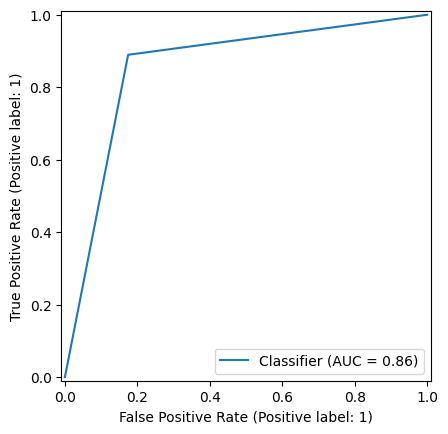

In [25]:
# final model evaluation
finalModel = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=2025,
                          max_depth = 9, min_child_weight = 5, subsample = 0.50, learning_rate = 0.03, n_estimators = 190)

finalModel.fit(X, y)
ypred = finalModel.predict(X)
RocCurveDisplay.from_predictions(y, ypred)                    

Confusion Matrix
[[2583  546]
 [ 369 2971]]


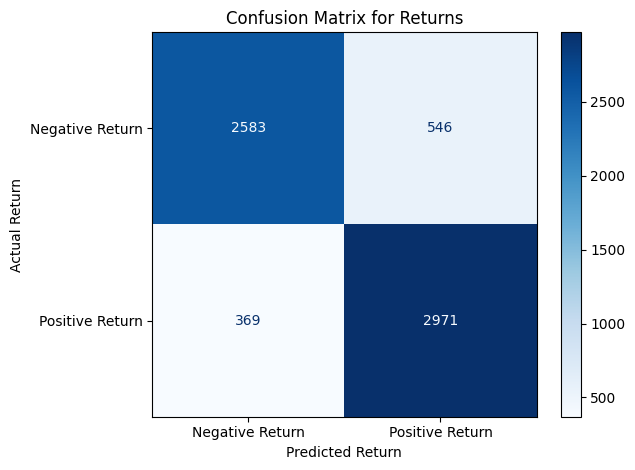

In [26]:
print("Confusion Matrix")
print(confusion_matrix(y, ypred))
disp = ConfusionMatrixDisplay.from_predictions(y, ypred,
                              display_labels =["Negative Return","Positive Return"],
                                              cmap = plt.cm.Blues)
plt.title("Confusion Matrix for Returns")
plt.xlabel("Predicted Return")
plt.ylabel("Actual Return")
plt.tight_layout()
plt.show()                              

In [27]:
print(classification_report(y, ypred, labels = ["0","1"]))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      3129
           1       0.84      0.89      0.87      3340

   micro avg       0.86      0.86      0.86      6469
   macro avg       0.86      0.86      0.86      6469
weighted avg       0.86      0.86      0.86      6469

